# Customer Satisfaction in the Brazilian E-Commerce Market

Customer satisfaction is an essential focal point to any business' growth: Satisfied customers are more likely to return, and dissatisfied customers are likely to share their opinions rapidly. Sending out customer satisfaction surveys is a decent method of pinpointing the reasons why people are not happy with their experience, but fails to account for bias where people not having the patience or time to complete a survey never have their voices heard. 

How can a company determine what's going wrong when the customers are silent? Collecting data about their experiences and analyzing similar clusters of customers may reveal underlying relationships between their reported rating and the key details of their transactions. From these results, the company can execute strategies to improve ineffective parts of the delivery system and market products more heavily that draw great satisfaction ratings.

Preliminary measures of success: silhouette score of clusters, 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

## Data Preprocessing

In [2]:
#E-Commerce CSVs
customers=pd.read_csv('olist_customers_dataset.csv')
geoloc=pd.read_csv('olist_geolocation_dataset.csv')
items=pd.read_csv('olist_order_items_dataset.csv')
payments=pd.read_csv('olist_order_payments_dataset.csv')  
reviews=pd.read_csv('olist_order_reviews_dataset.csv')
orders= pd.read_csv('olist_orders_dataset.csv') 
products=pd.read_csv('olist_products_dataset.csv')
sellers=pd.read_csv('olist_sellers_dataset.csv')
translations= pd.read_csv('product_category_name_translation.csv')

In [3]:
#Merge translations & drop Portuguese names
products_translated= products.merge(
    translations, how='left', 
    on='product_category_name').drop(
    columns='product_category_name')

In [4]:
#Use only payment info for unique orders
grouped_payments=payments.groupby('order_id').sum()

In [5]:
#Filter geolocations down to zip code centroids
grouped_locs= geoloc.groupby('geolocation_zip_code_prefix').mean()

In [6]:
#This merge contains each unique customer, order,
#How many payments, and total payment value
customer_orders= customers.merge(
    orders, how='left', on='customer_id').merge(
    reviews, how='left', on='order_id').merge(
    grouped_payments, how='left', on='order_id')

In [7]:
#Combine products, sellers, & items
seller_items= items.merge(
    sellers, how='left', on='seller_id').merge(
    products_translated, how='left', on='product_id').merge(
    grouped_locs, how='left', left_on='seller_zip_code_prefix',
    right_on='geolocation_zip_code_prefix')

In [8]:
#Merge 3 conglomerates w/o duplicate orders/customer ids
all_data=customer_orders.merge(
    seller_items, how='left', on='order_id').merge(
    grouped_locs, how='left', suffixes=['_customer', '_seller'], 
    left_on='customer_zip_code_prefix', 
    right_on='geolocation_zip_code_prefix')
all_data.shape

(114100, 42)

In [9]:
all_data=all_data.rename(
    columns={'product_name_lenght': 'product_name_length', 
             'product_description_lenght': 'product_description_length'})

In [50]:
#Define rows missing lats/longs
no_coords= all_data[pd.isnull(all_data.geolocation_lat_customer)]
no_coords_sellers= all_data[pd.isnull(all_data.geolocation_lat_seller)]

In [94]:
#Replace missing latitudes and longitudes with 
#values from rows by nearest zip code integer
def min_lat(row):
    row=all_data.iloc[row].customer_zip_code_prefix
    zips=all_data[pd.notnull(all_data.geolocation_lat_customer)]['customer_zip_code_prefix']
    #Find minimum distance b/w zip code integers
    closest= min(zips, key=lambda v: abs(row-v))
    #Return first matching result's latitude
    return all_data[all_data.customer_zip_code_prefix==closest].iloc[1]['geolocation_lat_customer']
def min_lng(row):
    row=all_data.iloc[row].customer_zip_code_prefix
    zips=all_data[pd.notnull(all_data.geolocation_lat_customer)]['customer_zip_code_prefix']
    #Find minimum distance b/w zip code integers
    closest= min(zips, key=lambda v: abs(row-v))
    #Return first matching result's longitude
    return all_data[all_data.customer_zip_code_prefix==closest].iloc[1]['geolocation_lng_customer']
#Copying functions for NaNs in seller geolocations
def min_lat_sellers(row):
    row=all_data.iloc[row].seller_zip_code_prefix
    zips=all_data[pd.notnull(all_data.geolocation_lat_seller)]['seller_zip_code_prefix']
    #Find minimum distance b/w zip code integers
    closest= min(zips, key=lambda v: abs(row-v))
    #Return first matching result's lat
    return all_data[all_data.seller_zip_code_prefix==closest].iloc[1]['geolocation_lat_seller']
def min_lng_sellers(row):
    row=all_data.iloc[row].seller_zip_code_prefix
    zips=all_data[pd.notnull(all_data.geolocation_lng_seller)]['seller_zip_code_prefix']
    #Find minimum distance b/w zip code integers
    closest= min(zips, key=lambda v: abs(row-v))
    #Return first matching result's long
    return all_data[all_data.seller_zip_code_prefix==closest].iloc[1]['geolocation_lng_seller']


In [95]:
#Initialize list of missing lat estimates
missing_lats=[]
missing_lngs=[]
for row in no_coords.index:
    missing_lats.append(min_lat(row))
    missing_lngs.append(min_lng(row))
#Fillna needs dict format to transmute values
lats_dict=dict(zip(no_coords.index, missing_lats))
lng_dict=dict(zip(no_coords.index, missing_lngs))

In [96]:
#Initialize list of missing lat estimates for sellers 
missing_lats_sellers=[]
missing_lngs_sellers=[]
for row in no_coords_sellers.index:
    missing_lats_sellers.append(min_lat_sellers(row))
    missing_lngs_sellers.append(min_lng_sellers(row))
#Fillna needs dict format to transmute values
lats_dict_sellers=dict(zip(no_coords_sellers.index, missing_lats_sellers))
lng_dict_sellers=dict(zip(no_coords_sellers.index, missing_lngs_sellers))

In [97]:
#Fill Values
all_data.geolocation_lat_customer=all_data.geolocation_lat_customer.fillna(lats_dict)
all_data.geolocation_lng_customer=all_data.geolocation_lng_customer.fillna(lng_dict)
all_data.geolocation_lat_seller=all_data.geolocation_lat_seller.fillna(lats_dict_sellers)
all_data.geolocation_lng_seller=all_data.geolocation_lng_seller.fillna(lng_dict_sellers)

In [18]:
dates=['order_purchase_timestamp', 'order_approved_at', 
       'order_delivered_carrier_date', 'order_delivered_customer_date',
      'order_estimated_delivery_date', 'shipping_limit_date']
for col in dates:
    all_data[col]=pd.to_datetime(all_data[col])

In [20]:
#Fill NaTs with average approval time
avg_approval_time=(all_data.order_approved_at-all_data.order_purchase_timestamp).mean()
all_data.order_approved_at=all_data.order_approved_at.fillna(
    all_data.order_purchase_timestamp+avg_approval_time)

In [24]:
available= all_data[(all_data.order_status!='unavailable')]
unavailable= all_data[(all_data.order_status=='unavailable')]

In [25]:
#Replace NaTs with sum of previous column and average time to assign delivery
avg_days_to_carrier= (all_data.order_delivered_carrier_date-all_data.order_approved_at).mean()

#Excluding order_status 'unavailable' as these were never delivered
all_data.order_delivered_carrier_date=available.order_delivered_carrier_date.fillna(
    all_data.order_approved_at+avg_days_to_carrier
)

In [26]:
#Repeat with customer dates
carrier_to_customer=(all_data.order_delivered_customer_date-all_data.order_delivered_carrier_date).mean()

#Excluding order_status 'unavailable' as these were never delivered
all_data.order_delivered_customer_date=available.order_delivered_customer_date.fillna(
    all_data.order_delivered_carrier_date+carrier_to_customer
)

In [28]:
#Check for similar products with existing values
all_data[pd.isnull(all_data.payment_value)]['product_id']

24296    5a6b04657a4c5ee34285d1e4619a96b4
24297    5a6b04657a4c5ee34285d1e4619a96b4
24298    5a6b04657a4c5ee34285d1e4619a96b4
Name: product_id, dtype: object

In [29]:
all_data[all_data.product_id==
         '5a6b04657a4c5ee34285d1e4619a96b4'].loc[
    :, 'payment_sequential':'payment_value']

,payment_sequential,payment_installments,payment_value
24296,NaN,NaN,NaN
24297,NaN,NaN,NaN
24298,NaN,NaN,NaN
68096,1.0,3.0,64.48


In [30]:
same_product=all_data.iloc[68096]

In [31]:
#Fill payment NaNs with values from row with same product ID
all_data.payment_sequential=all_data.payment_sequential.fillna(same_product.payment_sequential)
all_data.payment_installments=all_data.payment_installments.fillna(same_product.payment_installments)
all_data.payment_value=all_data.payment_value.fillna(same_product.payment_value)

In [32]:
#No Need for reviews/comments
all_data=all_data.drop(columns={'review_comment_title', 'review_comment_message'})

In [34]:
#Impute character melgth categories with mean
all_data.product_name_length=all_data.product_name_length.fillna(
    all_data.product_name_length.mean())
all_data.product_description_length=all_data.product_description_length.fillna(
    all_data.product_description_length.mean())
all_data.product_photos_qty=all_data.product_photos_qty.fillna(
    all_data.product_photos_qty.mean())
#Impute missing category names with 'Other'
all_data.product_category_name_english=all_data.product_category_name_english.fillna('Other')

In [60]:
#No Product ID to reference -
#Impute measurement variables with mean
measurements=['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']
for col in measurements:
    all_data[col]=all_data[col].fillna(all_data[col].mean())


In [36]:
#Treat outliers
numeric= all_data.select_dtypes(include=['float64', 'int64'])
for col in numeric:
    numeric.loc[:, col], _ =boxcox(numeric.loc[:, col]+75)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:910: RuntimeWarning: divide by zero encountered in log
  return (lmb - 1) * np.sum(logdata, axis=0) - N/2 * np.log(variance)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/optimize.py:1959: RuntimeWarning: invalid value encountered in double_scalars


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


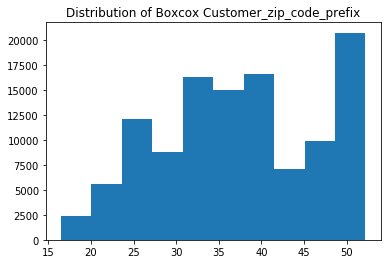

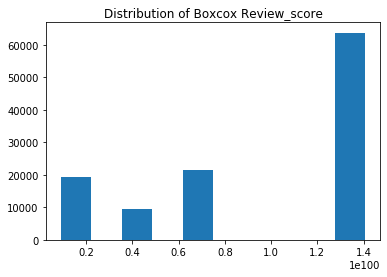

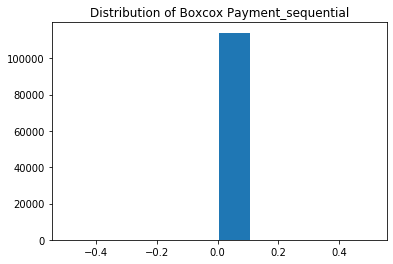

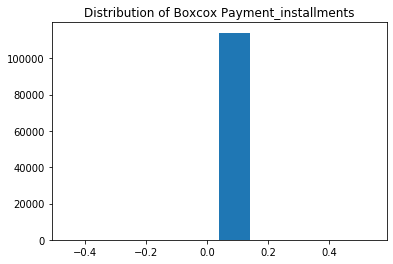

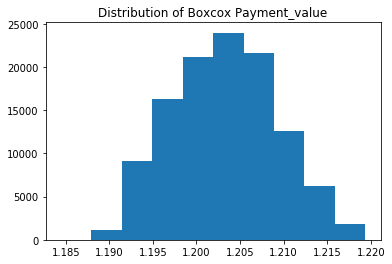

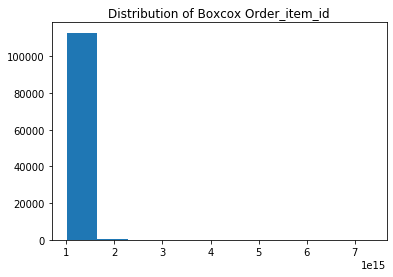

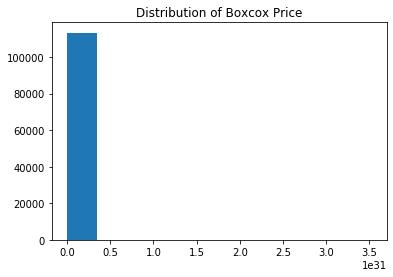

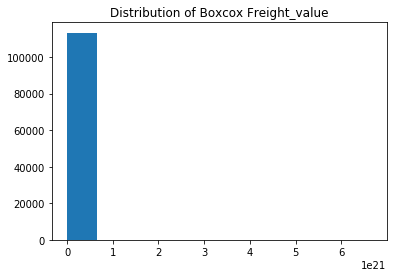

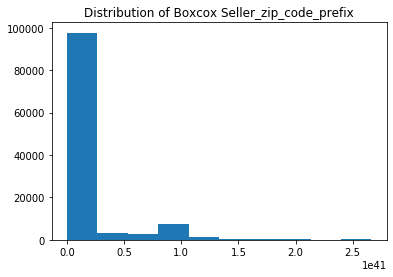

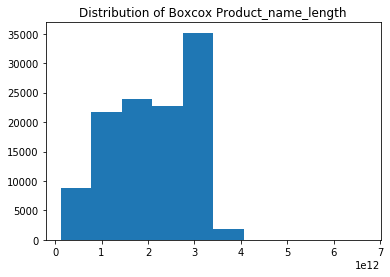

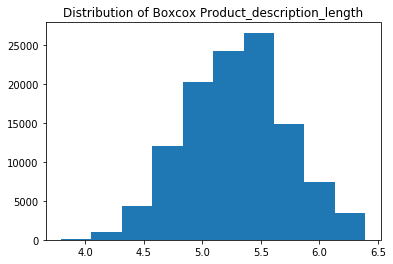

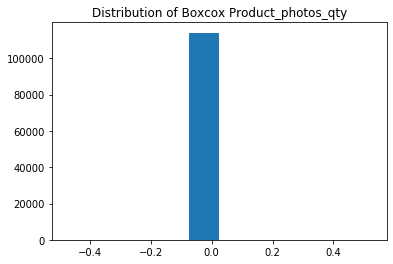

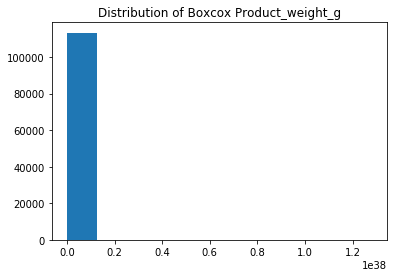

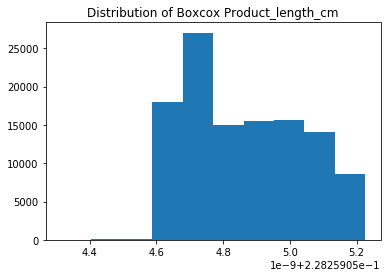

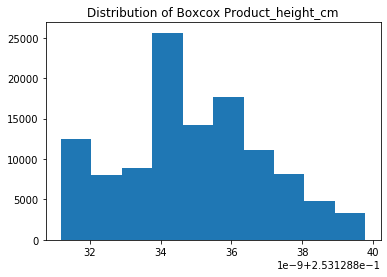

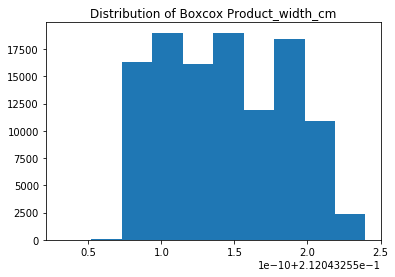

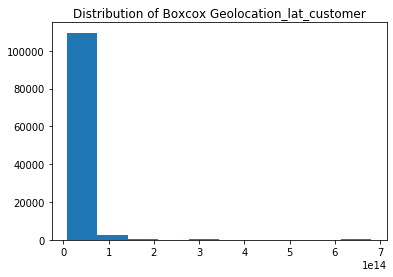

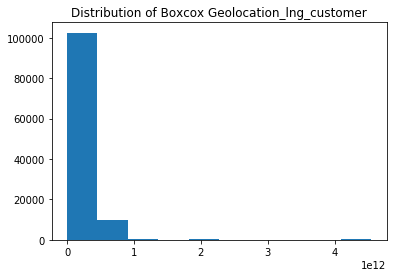

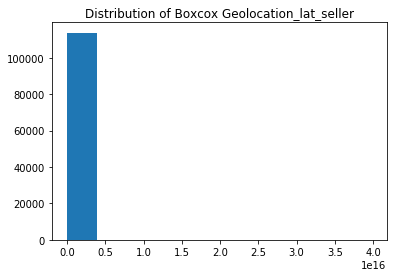

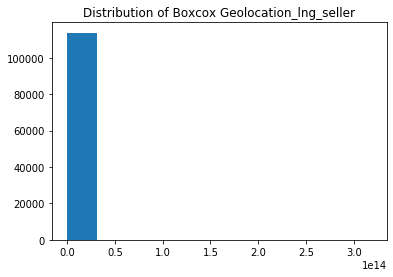

In [37]:
for i, col in enumerate(numeric):
    plt.figure(i)
    plt.title('Distribution of Boxcox {}'.format(col.capitalize()))
    plt.hist(numeric[col])

## EDA
## Questions to mull over

1. How do review scores differ by product category?
2. Do larger items cost more? Any correlation with lower satisfaction?
3. Do products that travel farther induce lower review scores?
4. 

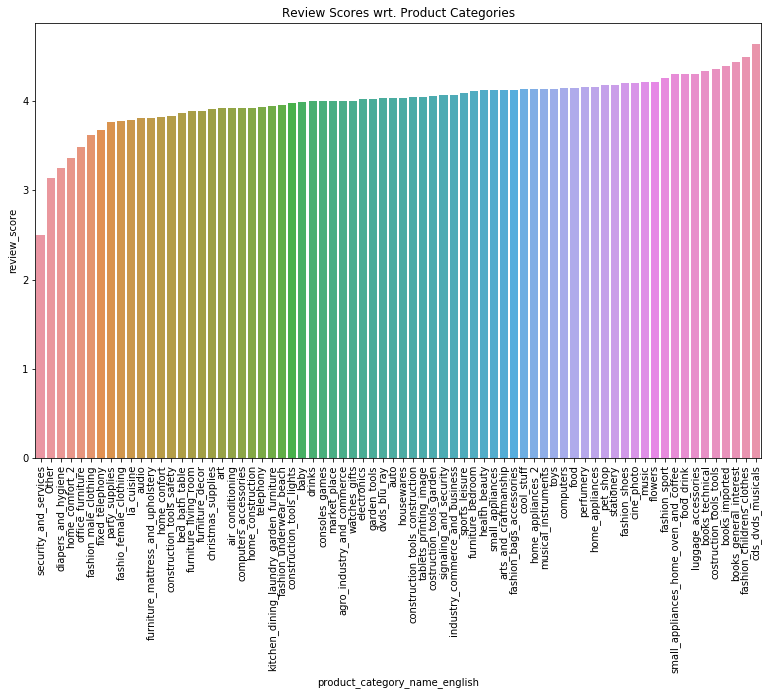

In [104]:
plt.figure(figsize=(13, 8))
ax=sns.barplot(all_data.groupby('product_category_name_english').mean()['review_score'].sort_values().index, 
            all_data.groupby('product_category_name_english').mean()['review_score'].sort_values(), 
           )
for item in ax.get_xticklabels(): item.set_rotation(90)
plt.title('Review Scores wrt. Product Categories')
plt.show()

The barplot reveals that the first four product categories (security & services, diapers & hygiene, home comfort, and office furniture) yield review scores far below average